# Notebook of Figure 6 of manuscript titled: _Variability of the kinetic energy in seasonally ice-covered oceans_.
by Josue Martinez-Moreno, Camille Lique, Claude Talandier, Quentin
Jamet, & Anne-Marie Treguier

This figure shows montly spectra analysis of the kinetic energy field at the surface and interior. Additionally, the seasonal cycle of the first baroclinic Rossby radius of deformation is plotted.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
# import xrftd
import matplotlib.colors as colors

In [2]:
import xrft

In [3]:
import nc_time_axis

In [4]:
from dask.distributed import Client
import dask
import os

# os.environ["MALLOC_TRIM_THRESHOLD_"] = str(dask.config.get("distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_"))
client =Client(n_workers=8, threads_per_worker=1, memory_limit="4 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38375,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:47533,Total threads: 1
Dashboard: http://127.0.0.1:47499/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:50945,


In [5]:
from utils import Import_Expt_Front, date_fmt

## Load data

In [6]:
folder = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/'
EXF = Import_Expt_Front(folder)

In [7]:
exp_filter = ['expt_001','expt_002','expt_003','expt_004','expt_005','expt_007','expt_008','expt_009','expt_010','expt_250m_test']


In [8]:
dataset_gridT_1d = EXF.import_multipe_expt('grid_T',vars_of_interest=['ke'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1},decode_cf=False)


In [9]:
dataset_gridT_1d = xr.decode_cf(dataset_gridT_1d)

In [10]:
from utils import compute_PSD, compute_PSD_dataset 

In [11]:
## Functions to compute the PSD of a dataset.

def compute_PSD_dataset(dataset,indx=None):    
    dataset_dict = {}
    for var in list(dataset.data_vars):
        if indx!=None:
            FFT, PSD, om_welch = compute_PSD(dataset[var].isel(indx),dx=250)
        else:
            FFT, PSD, om_welch = compute_PSD(dataset[var],dx=250)
            
        dataset_dict[var+"_FFT"] = {'dims':('n','x'),'data': FFT} 
        dataset_dict[var+"_PSD"] = {'dims':('n','x'),'data':PSD,'attrs':{'long_name':dataset[var].long_name,'units':dataset[var].units}} 
        dataset_dict[var+"_om"] = {'dims':('n','x'),'data':om_welch}
    dataset = xr.Dataset.from_dict(dataset_dict)
    return dataset

def compute_PSD_dataset_2D(dataset,var,indx=None):    
#     dataset_dict = dataset.copy()
#     dataset_dict.expand_dims(dim={"axis": len(dataset[indx])})
    dataset_dict=[]
    for ii in dataset[indx].values:
        dataset_out = compute_PSD_dataset(dataset.sel({indx:ii}))
        dataset_dict.append(dataset_out)
        concat_dataset = xr.concat(dataset_dict,dim="y")
    concat_dataset['n']=dataset.time_counter.values
    return concat_dataset.rename({"n":"time"}).transpose("time","x","y")

## Compute the KE and spectra

In [12]:
ke_surface = dataset_gridT_1d.sel(deptht=5,method="nearest").sel(time_counter='0002')


In [13]:
## Uncomment to compute the spectra at 5m.
# data = ke_surface.isel(y=slice(100,1100)).load()
# PSD_ke = compute_PSD_dataset_2D(data,'ke_006','y')
# PSD_ke.to_netcdf('./storage/spectra_5m_KE_125km.nc')

In [14]:
# Load spectra at 5m
PSD_ke= xr.open_dataset('./storage/spectra_5m_KE_125km.nc')

In [15]:
L1 = 8; L2 = 2*np.pi*L1

In [16]:
ke_150m = dataset_gridT_1d.sel(deptht=150,method="nearest").sel(time_counter='0002')


In [17]:
## Uncomment to compute the spectra at 150m.
# data_100m = ke_150m.isel(y=slice(100,1100)).load()
# PSD_ke_100m = compute_PSD_dataset_2D(data_100m,'ke_006','y')
# PSD_ke_100m.to_netcdf('./storage/spectra_150m_KE_125km.nc')

In [18]:
# Load spectra at 150m
PSD_ke_100m = xr.open_dataset('./storage/spectra_150m_KE_125km.nc')

In [19]:
import matplotlib
def add_distance_axis(ax,fontsize=12):
    ax_ = ax.twiny()

    ax_.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax_.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax_.spines['bottom'].set_position(('outward', 36))
    ax_.set_xlim(ax.get_xlim())
    ax_.set_xlabel("Wavelength [km]", fontsize= fontsize)


    labels = ax_.get_xticklabels()
    new_label=list(np.zeros(len(labels)))
    count=0
    for label in labels:
        nl = np.round(1 / label.get_position()[0], 1)
        if nl==np.inf:
            new_label[count] = "Inf"
        else:
            new_label[count] = "{0}".format(nl)
        count+=1

    ax_.set_xticklabels(new_label) 
    
    return ax_


def add_distance_axis_log(ax,fontsize=12):
    ax_ = ax.twiny()

    ax_.set_xscale('log')
    ax_.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax_.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax_.spines['bottom'].set_position(('outward', 36))
    ax_.set_xlim(ax.get_xlim())
    ax_.set_xlabel("Wavelength [km]", fontsize= fontsize)


    labels = ax_.get_xticklabels()
    new_label=list(np.zeros(len(labels)))
    count=0
    for label in labels:
        nl = np.round(1 / label.get_position()[0], 1)
        if nl==np.inf:
            new_label[count] = "Inf"
        else:
            new_label[count] = "{0}".format(nl)
        count+=1

    ax_.set_xticklabels(new_label)
    
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(1/np.arange(1,10)),numticks=12)
    ax_.xaxis.set_minor_locator(locmin)
    ax_.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    
    return ax_



### Load Rossby Radious

In [20]:
R1_ts = xr.open_dataset("./storage/Rossby_radius.nc")
R1_ts_STD = xr.open_dataset("./storage/Rossby_radius_STD.nc")

In [21]:
R1min = np.min(R1_ts.bn2_006).values/1000
R1max = np.max(R1_ts.bn2_006).values/1000

In [22]:
from numpy import mean, absolute
from scipy import stats

def mad(data, axis=None):
    return stats.median_abs_deviation(data,axis)
#mean(absolute(data - mean(data, axis)), axis)

## Plotting

In [23]:
import colorcet as cct

In [24]:
colors = cct.cm.CET_C1s(np.linspace(0,1,12))

In [25]:
def axis_to_fig(axis):
    fig = axis.figure
    def transform(coord):
        return fig.transFigure.inverted().transform(
            axis.transAxes.transform(coord))
    return transform

def add_sub_axes(axis, rect,**kwargs):
    fig = axis.figure
    left, bottom, width, height = rect
    trans = axis_to_fig(axis)
    figleft, figbottom = trans((left, bottom))
    figwidth, figheight = trans([width,height]) - trans([0,0])
    return fig.add_axes([figleft, figbottom, figwidth, figheight],**kwargs)

def myfmt(x, pos):
    return '{0:.2f}'.format(x)

import datetime
def date_fmt(date):
    if len(date)>2:
        format = '%m-%d'
        outformat = '%d - %B'
    else:
        format = '%m'
        outformat = '%B'
    return datetime.datetime.strptime(str(date), format).strftime(outformat)


fontsize=12

/dev/shm/pbs.3982686.datarmor0/ipykernel_26338/689598169.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_.set_xticklabels(new_label)
/dev/shm/pbs.3982686.datarmor0/ipykernel_26338/689598169.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_.set_xticklabels(new_label)
/dev/shm/pbs.3982686.datarmor0/ipykernel_26338/1540538490.py:200: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  rosax.set_xticklabels(updated_labels,fontsize=12)


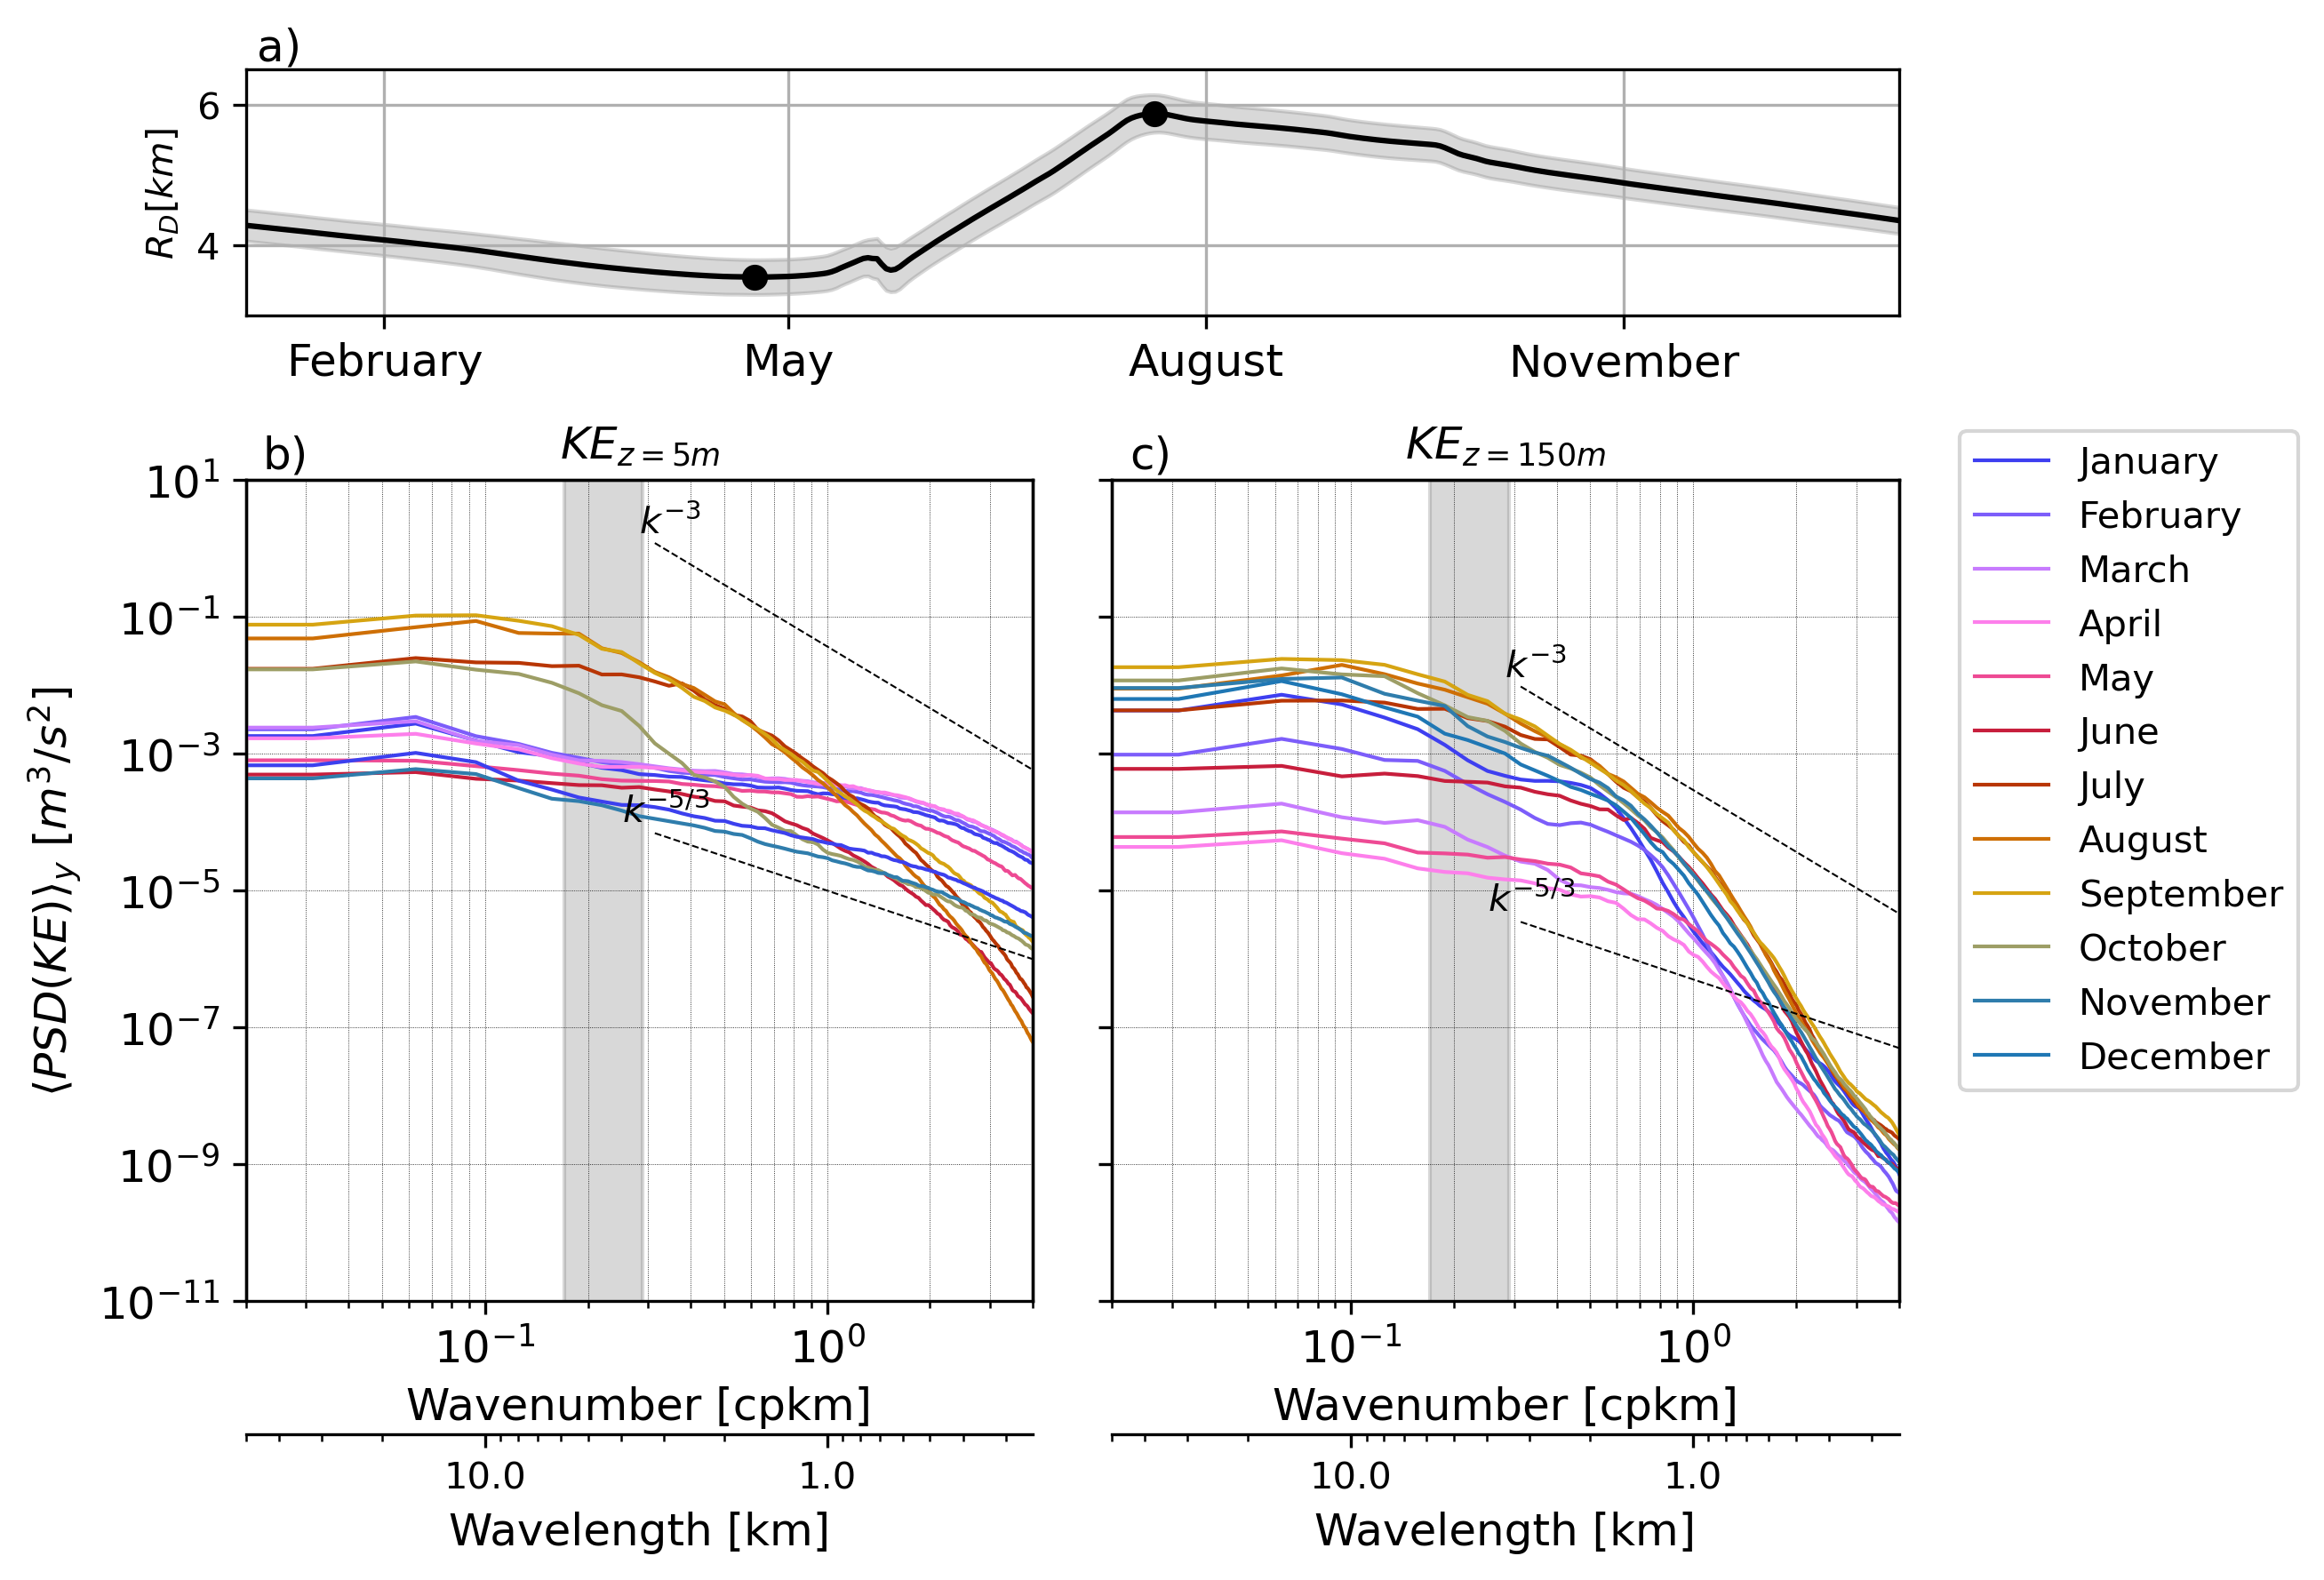

In [26]:
fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=300)#,sharey=True)

#####
rosax = add_sub_axes(ax[0],[0., 1.2, 2.2, 0.3])

(R1_ts.bn2_006/1000).sel(time_counter="0002").plot(ax=rosax,color='k')
time = R1_ts.sel(time_counter="0002").time_counter.values

# rosax.fill_between([time[0],time[-1],time[-1],time[0]],
#                    [R1min,R1min,R1max,R1max],color='gray',alpha=0.3)

rosax.fill_between(time,(R1_ts.bn2_006/1000).sel(time_counter="0002"),((R1_ts.bn2_006 + R1_ts_STD.bn2_006)/1000).sel(time_counter="0002"),color='gray',alpha=0.3)
rosax.fill_between(time,(R1_ts.bn2_006/1000).sel(time_counter="0002"),((R1_ts.bn2_006 - R1_ts_STD.bn2_006)/1000).sel(time_counter="0002"),color='gray',alpha=0.3)

plt.plot(time[(R1_ts.bn2_006.sel(time_counter="0002")/1000).argmax()],(R1_ts.bn2_006.sel(time_counter="0002")/1000).max(),'o',color='k')
plt.plot(time[(R1_ts.bn2_006.sel(time_counter="0002")/1000).argmin()],(R1_ts.bn2_006.sel(time_counter="0002")/1000).min(),'o',color='k')

rosax.set_xlim((time[0],time[-1]))
rosax.set_ylim((3,6.5))

rosax.set_ylabel("$R_D[km]$")
rosax.set_xlabel("")
rosax.grid()

#####

xaxis = PSD_ke["ke_006_om"].mean('y')*1000
PSD =  PSD_ke["ke_006_PSD"].mean('y')
mean_PSD = PSD.groupby("time.month").mean()

min_PSD = 10 * PSD_ke["ke_006_PSD"].min('y').groupby("time.month").mean()
max_PSD = PSD_ke["ke_006_PSD"].max('y').groupby("time.month").mean()
# std_PSD = PSD.groupby("time.season").std()

label=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

ax0 = ax[0]
mm=1
ax0.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,color=colors[mm-1],zorder=3, label=label[mm-1])

mm=2
ax0.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,color=colors[mm-1],zorder=3, label=label[mm-1])

mm=3
ax0.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,color=colors[mm-1],zorder=3, label=label[mm-1])

mm=4
ax0.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,color=colors[mm-1],zorder=3, label=label[mm-1])

mm=5
ax0.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,color=colors[mm-1],zorder=3, label=label[mm-1])

mm=6
ax0.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,color=colors[mm-1],zorder=3, label=label[mm-1])

mm=7
ax0.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,color=colors[mm-1],zorder=3, label=label[mm-1])

mm=8
ax0.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,color=colors[mm-1],zorder=3, label=label[mm-1])

mm=9
ax0.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,color=colors[mm-1],zorder=3, label=label[mm-1])

mm=10
ax0.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,color=colors[mm-1],zorder=3, label=label[mm-1])

mm=11
ax0.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,color=colors[mm-1],zorder=3, label=label[mm-1])

mm=12
ax0.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,color=colors[mm-1],zorder=3, label=label[mm-1])

ax0.set_yscale('log')
ax0.set_xscale('log')

ax0.plot(xaxis[0,10:200],(xaxis[0,10:200]*1000)**(-5/3),linestyle='--',linewidth=0.5,color='k',zorder=5)
ax0.text(xaxis[0,8],(xaxis[0,8]*1000)**(-5/3), r"$k^{-5/3}$")

ax0.plot(xaxis[0,10:200],(xaxis[0,10:200]*3)**-3,linestyle='--',linewidth=0.5,color='k',zorder=5)
ax0.text(xaxis[0,9],(xaxis[0,9]*3)**-3, r"$k^{-3}$")


ax0.set_xlabel(r'$k$ [cpkm]', fontsize= 12 )
ax0.tick_params(labelsize=12)
ax0.grid(which='major', linestyle=':', linewidth='0.2', color='black')
ax0.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
ax0.fill_between([1/R1min,1/R1max,1/R1max,1/R1min],[1e-13,1e-13,1e1,1e1],color='gray',alpha=0.3)
ax0.set_title(r'$KE_{z=5m}$')

ax0.set_ylabel(r'$\left<PSD(KE)\right>_y$ [$m^3/s^2]$', fontsize= fontsize )

ax0.set_ylim((1e-11,1e1))
# ax0.legend(bbox_to_anchor=(1.02, 1.03))
ax0.set_xlim((1/50,1/0.25))

################################################################################
################################################################################
################################################################################

ax1=ax[1]

xaxis = PSD_ke_100m["ke_006_om"].mean('y')*1000
PSD =  PSD_ke_100m["ke_006_PSD"].mean('y')
mean_PSD = PSD.groupby("time.month").mean()

min_PSD = 10 * PSD_ke["ke_006_PSD"].min('y').groupby("time.month").mean()
max_PSD = PSD_ke["ke_006_PSD"].max('y').groupby("time.month").mean()
# std_PSD = PSD.groupby("time.season").std()

# colors = plt.cm.colorwarm(np.linspace(0,1,12))
label=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

mm=1
ax1.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,zorder=3, label=label[mm-1], color=colors[mm-1])

mm=2
ax1.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,zorder=3, label=label[mm-1], color=colors[mm-1])

mm=3
ax1.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,zorder=3, label=label[mm-1], color=colors[mm-1])

mm=4
ax1.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,zorder=3, label=label[mm-1], color=colors[mm-1])

mm=5
ax1.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,zorder=3, label=label[mm-1], color=colors[mm-1])

mm=6
ax1.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,zorder=3, label=label[mm-1], color=colors[mm-1])

mm=7
ax1.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,zorder=3, label=label[mm-1], color=colors[mm-1])

mm=8
ax1.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,zorder=3, label=label[mm-1], color=colors[mm-1])

mm=9
ax1.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,zorder=3, label=label[mm-1], color=colors[mm-1])

mm=10
ax1.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,zorder=3, label=label[mm-1], color=colors[mm-1])

mm=11
ax1.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,zorder=3, label=label[mm-1], color=colors[mm-1])

mm=12
ax1.plot(xaxis[0,:],mean_PSD.sel(month=mm),linewidth=1,zorder=3, label=label[mm-1])
# ax.fill_between(xaxis[0,:], min_PSD.sel(month=mm), max_PSD.sel(month=mm), color="indigo", alpha=0.1)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.plot(xaxis[0,10:200],(xaxis[0,10:200]*6000)**(-5/3),linestyle='--',linewidth=0.5,color='k',zorder=5)
ax1.text(xaxis[0,8],(xaxis[0,8]*6000)**(-5/3), r"$k^{-5/3}$")

ax1.plot(xaxis[0,10:200],(xaxis[0,10:200]*15)**-3,linestyle='--',linewidth=0.5,color='k',zorder=5)
ax1.text(xaxis[0,9],(xaxis[0,9]*15)**-3, r"$k^{-3}$")

ax1.set_xlabel(r'$k$ [cpkm]', fontsize= 12 )
ax1.tick_params(labelsize=12)
ax1.grid(which='major', linestyle=':', linewidth='0.2', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
ax1.fill_between([1/R1min,1/R1max,1/R1max,1/R1min],[1e-13,1e-13,1e1,1e1],color='gray',alpha=0.3)
ax1.set_title(r'$KE_{z=150m}$')
ax1.set_ylim((1e-11,1e1))
ax1.set_xlim((1/50,1/0.25))

ax1.yaxis.set_ticklabels([])

plt.subplots_adjust(wspace=0.1)

rosax.text(0.02, 1.09, 'a)', horizontalalignment='center', verticalalignment='center', transform = rosax.transAxes,fontsize=12)
ax0.text(0.05, 1.03, 'b)', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes,fontsize=12)
ax1.text(0.05, 1.03, 'c)', horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes,fontsize=12)

##################################################################################################################################

ax0.set_xlabel("Wavenumber [cpkm]", fontsize= fontsize)

add_distance_axis_log(ax0)



##################################################################################################################################

ax1.set_xlabel("Wavenumber [cpkm]", fontsize= fontsize)


add_distance_axis_log(ax1)



##################################################################################################################################

plt.draw()

labels = [item.get_text() for item in rosax.get_xticklabels()]
updated_labels = [ date_fmt(label[5:10]) for label in labels]
rosax.set_xticklabels(updated_labels,fontsize=12)

ax1.legend(bbox_to_anchor=(0.92, 0.29),bbox_transform=fig.transFigure)

plt.savefig('./figures/Fig_6_spectra_2d_monthly.pdf',dpi=300,bbox_inches='tight')

**Figure 6.** a) Time series of the domain average Rossby radius ($R_D$) for the second year of the simulation. The shading area correspond to the Rossby radius standard deviation, and the dots correspond to the $R_D$ maxima and minima of the year ($5.9\ km$  and $3.4\ km$, respectively).
  Monthly averaged kinetic energy spectra at b) $5\ m$ and c) $150\ m$ depth. Vertical shaded area in panels b) and c) matches the maxima and minima of the $R_D$ shown in panel a).

## Extra diagnostics

In [27]:
# Range or Rossby Radius and inverse of Rossby Radius
1/R1min, 1/R1max, R1min, R1max

(0.2895854249589839,
 0.17023251145014096,
 3.4532124679328646,
 5.8743185510300595)